In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, skewness, count, mean, stddev, isnan, lit, col,sum as spark_sum
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline


# 1. Initialize Spark
spark = SparkSession.builder.appName("HMDA_Preprocessing").getOrCreate()


# 2. Load data with 5000 sample rows
df = spark.read.csv("hmda_2016_sample.csv", header=True, inferSchema=True)
print("Initial data shape:", (df.count(), len(df.columns)))



# 4. Handle nulls 

numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float')]
for c in numeric_cols:
    df = df.withColumn(c, when(isnan(col(c)) | col(c).isNull(), None).otherwise(col(c)))

# Compute skewness for numeric columns
skew_data = df.select([skewness(col(c)).alias(c) for c in numeric_cols]).collect()[0].asDict()
print("Skewness:", skew_data)

# Impute based on skewness
# For right-skewed columns → median, for left-skewed → mean
for c in numeric_cols:
    col_skew = skew_data[c]
    if col_skew is not None:
        if abs(col_skew) > 1:
            # Median imputation for skewed data
            median_val = df.approxQuantile(c, [0.5], 0.01)[0]
            df = df.na.fill({c: median_val})
        else:
            # Mean imputation otherwise
            mean_val = df.select(F.mean(col(c))).first()[0]
            df = df.na.fill({c: mean_val})


# 5. Remove outliers (using IQR)

for c in numeric_cols:
    try:
        quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
        if len(quantiles) < 2:
            print(f"Skipping {c} - insufficient data for IQR")
            continue

        q1, q3 = quantiles
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df.filter((col(c) >= lower) & (col(c) <= upper))
    except Exception as e:
        print(f"Skipping {c} due to error: {e}")
        continue

# 6. Remove zero-variance and near-zero variance columns

stats = df.select([(F.variance(col(c)).alias(c)) for c in numeric_cols]).collect()[0].asDict()
low_var_cols = [c for c, v in stats.items() if v is None or v < 1e-5]
df = df.drop(*low_var_cols)
print("Removed low variance columns:", low_var_cols)


# 7. Remove highly correlated attributes

remaining_numeric = [c for c in df.columns if c in numeric_cols and c not in low_var_cols]

assembler = VectorAssembler(inputCols=remaining_numeric, outputCol="features")
df_vec = assembler.transform(df).select("features")

corr_matrix = Correlation.corr(df_vec, "features").head()[0].toArray()

# Drop one of each pair of highly correlated columns
to_drop = set()
for i in range(len(remaining_numeric)):
    for j in range(i + 1, len(remaining_numeric)):
        if abs(corr_matrix[i][j]) > 0.9:
            to_drop.add(remaining_numeric[j])
df = df.drop(*list(to_drop))
print("Dropped highly correlated columns:", list(to_drop))


print("Data shape:", (df.count(), len(df.columns)))
df.show(5)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/27 12:03:32 WARN Utils: Your hostname, MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.165 instead (on interface en0)
25/10/27 12:03:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/27 12:03:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Initial data shape: (5000, 78)


25/10/27 12:03:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Skewness: {'as_of_year': None, 'agency_code': -1.133557610752084, 'loan_type': 1.545307862548966, 'property_type': 6.477759409275815, 'loan_purpose': -0.06631160538001363, 'owner_occupancy': 3.2692081888329367, 'loan_amount_000s': 13.246193188807139, 'preapproval': -2.704683294662515, 'action_taken': 0.7926353514882726, 'msamd': -0.1740281799089542, 'state_code': 0.1789081233380773, 'county_code': 3.2814795595246715, 'census_tract_number': 1.367942936743142, 'applicant_ethnicity': 1.0546734106604552, 'co_applicant_ethnicity': -0.44057157346257925, 'applicant_race_1': -0.8732381845762832, 'applicant_race_2': -1.1860104552658883, 'applicant_race_3': None, 'co_applicant_race_1': -0.9055591729925622, 'co_applicant_race_2': -1.9388768742861848, 'applicant_sex': 1.2990363212262155, 'co_applicant_sex': -0.45824476121158225, 'applicant_income_000s': 10.299430074770887, 'purchaser_type': 1.617201818252887, 'denial_reason_1': 0.6015422614842352, 'denial_reason_2': 0.9020591378654562, 'denial_rea

25/10/27 12:03:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Dropped highly correlated columns: ['co_applicant_race_1', 'co_applicant_sex']
Data shape: (120, 59)
+-------------+--------------------+-----------+-----------+--------------+---------+--------------------+-----------------+------------+--------------------+----------------+----------------+--------------------+------------+--------------------+-----------------+----------+----------+----------+-----------------+-----------+-------------------+------------------------+---------------------------+----------------------+---------------------+---------------------+---------------------+---------------------+----------------+---------------------+----------------+------------------------+------------------------+------------------------+-------------------+------------------------+-------------------+------------------------+-------------------+------------------+-------------+---------------------+---------------------+--------------------+--------------+--------------------+------------

In [2]:

# Get null counts for each column
null_counts = []
for column_name in df.columns:
    null_count = df.filter(col(column_name).isNull()).count()
    null_counts.append((column_name, null_count))

# Display results
print("Null/Missing Values Count by Column:")
print("-" * 50)
for column_name, count in null_counts:
    print(f"{column_name}: {count}")

# Also check for NaN values in numeric columns
print("\nNaN Values Count by Column:")
print("-" * 50)
for column_name, count in null_counts:
    if column_name in [c for c, t in df.dtypes if t in ('int', 'double', 'float')]:
        nan_count = df.filter(isnan(col(column_name))).count()
        if nan_count > 0:
            print(f"{column_name}: {nan_count}")

# Summary statistics
total_nulls = sum([count for _, count in null_counts])
print(f"\nTotal null/missing values across all columns: {total_nulls}")
# print(f"Columns with nulls: {len([name for name, count in null_counts if count > 0])}")
# print(f"Columns without nulls: {len([name for name, count in null_counts if count == 0])}")


Null/Missing Values Count by Column:
--------------------------------------------------
respondent_id: 0
agency_name: 0
agency_abbr: 0
agency_code: 0
loan_type_name: 0
loan_type: 0
property_type_name: 0
loan_purpose_name: 0
loan_purpose: 0
owner_occupancy_name: 0
loan_amount_000s: 0
preapproval_name: 0
action_taken_name: 0
action_taken: 0
msamd_name: 8
msamd: 0
state_name: 2
state_abbr: 2
state_code: 0
county_name: 2
county_code: 0
census_tract_number: 0
applicant_ethnicity_name: 0
co_applicant_ethnicity_name: 0
co_applicant_ethnicity: 0
applicant_race_name_1: 0
applicant_race_name_2: 120
applicant_race_name_3: 120
applicant_race_name_4: 120
applicant_race_4: 120
applicant_race_name_5: 120
applicant_race_5: 120
co_applicant_race_name_1: 0
co_applicant_race_name_2: 120
co_applicant_race_name_3: 120
co_applicant_race_3: 120
co_applicant_race_name_4: 120
co_applicant_race_4: 120
co_applicant_race_name_5: 120
co_applicant_race_5: 120
applicant_sex_name: 0
applicant_sex: 0
co_applicant_sex_

In [3]:
# Calculate total number of rows
total_rows = df.count()
print(f"Total rows in dataset: {total_rows}")

# Define threshold for majority (50% or more)
threshold = 0.7
majority_threshold = total_rows * threshold

print(f"Majority threshold (70% of {total_rows} rows): {majority_threshold}")

# Find columns with majority null/missing values
columns_to_drop = []
null_analysis = []

for column_name in df.columns:
    # Count null values
    null_count = df.filter(col(column_name).isNull()).count()
    
    # Count NaN values for numeric columns
    nan_count = 0
    if column_name in [c for c, t in df.dtypes if t in ('int', 'double', 'float')]:
        nan_count = df.filter(isnan(col(column_name))).count()
    
    # Total missing values
    total_missing = null_count + nan_count
    missing_percentage = (total_missing / total_rows) * 100
    
    null_analysis.append({
        'column': column_name,
        'null_count': null_count,
        'nan_count': nan_count,
        'total_missing': total_missing,
        'missing_percentage': missing_percentage
    })
    
    # Check if majority is missing
    if total_missing >= majority_threshold:
        columns_to_drop.append(column_name)

# Display analysis
print("\nMissing Values Analysis:")
print("-" * 80)
print(f"{'Column':<30} {'Nulls':<8} {'NaNs':<8} {'Total':<8} {'% Missing':<10} {'Action'}")
print("-" * 80)

for analysis in null_analysis:
    action = "DROP" if analysis['column'] in columns_to_drop else "KEEP"
    print(f"{analysis['column']:<30} {analysis['null_count']:<8} {analysis['nan_count']:<8} {analysis['total_missing']:<8} {analysis['missing_percentage']:<10.2f} {action}")

# Drop columns with majority missing values
if columns_to_drop:
    print(f"\nDropping {len(columns_to_drop)} columns with majority missing values:")
    for col in columns_to_drop:
        print(f"  - {col}")
    
    df = df.drop(*columns_to_drop)
    print(f"\nDataset shape after dropping columns: {df.count()} rows, {len(df.columns)} columns")
else:
    print("\nNo columns found with majority missing values.")



Total rows in dataset: 120
Majority threshold (70% of 120 rows): 84.0

Missing Values Analysis:
--------------------------------------------------------------------------------
Column                         Nulls    NaNs     Total    % Missing  Action
--------------------------------------------------------------------------------
respondent_id                  0        0        0        0.00       KEEP
agency_name                    0        0        0        0.00       KEEP
agency_abbr                    0        0        0        0.00       KEEP
agency_code                    0        0        0        0.00       KEEP
loan_type_name                 0        0        0        0.00       KEEP
loan_type                      0        0        0        0.00       KEEP
property_type_name             0        0        0        0.00       KEEP
loan_purpose_name              0        0        0        0.00       KEEP
loan_purpose                   0        0        0        0.00       KEEP


In [4]:
print("Data shape:", (df.count(), len(df.columns)))
df.show(5)

Data shape: (120, 43)
+-------------+--------------------+-----------+-----------+--------------+---------+--------------------+-----------------+------------+--------------------+----------------+----------------+--------------------+------------+--------------------+-----------------+----------+----------+----------+-----------------+-----------+-------------------+------------------------+---------------------------+----------------------+---------------------+------------------------+------------------+-------------+---------------------+---------------------+--------------------+--------------+-----------------+--------------------+--------------------+---------------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+
|respondent_id|         agency_name|agency_abbr|agency_code|loan_type_name|loan_type|  property_type_name|loan_purpose_name|loan_purpose|owner_occupancy_name|loan_amount_000s|pre

In [5]:
# the target column was droped, so I will create it again
df = df.withColumn('target',
                   F.when(df['action_taken'] == 1, 1).otherwise(0)
                  )
# we want to remove action_taken here, when we run the information gain, 
# it will only look at that column and our other features would not allow for 
# us to see the importance of that column

df = df.drop('action_taken')

In [6]:
# print the number of 0 and 1 in the target column
target_counts = df.groupBy("target").count()
target_counts.show()

# print the number of rows in the dataset
print(f"Total number of rows: {df.count()}")



+------+-----+
|target|count|
+------+-----+
|     1|   79|
|     0|   41|
+------+-----+

Total number of rows: 120


In [7]:
print("Final shape:", (df.count(), len(df.columns)))
df.show(5)

Final shape: (120, 43)
+-------------+--------------------+-----------+-----------+--------------+---------+--------------------+-----------------+------------+--------------------+----------------+----------------+--------------------+--------------------+-----------------+----------+----------+----------+-----------------+-----------+-------------------+------------------------+---------------------------+----------------------+---------------------+------------------------+------------------+-------------+---------------------+---------------------+--------------------+--------------+-----------------+--------------------+--------------------+---------------+----------+-------------------+------------------------+---------------------+------------------------------+-----------------------------+------+
|respondent_id|         agency_name|agency_abbr|agency_code|loan_type_name|loan_type|  property_type_name|loan_purpose_name|loan_purpose|owner_occupancy_name|loan_amount_000s|preappro

## Feature Selection

In [8]:
# -------------------------------
# Information Gain Feature Selection 

target_col = 'target'
# -------------------------------
# 2. Identify numeric features (skip non-feature columns)
# -------------------------------
exclude_cols = ['respondent_id', 'edit_status_name', 'county_name', 'msamd_name', 'state_name', 'state_abbr','target']
numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float') and c not in exclude_cols]

print(f"Numeric features found: {len(numeric_cols)}")
print("Sample numeric columns:", numeric_cols[:10])

if not numeric_cols:
    raise ValueError("No numeric columns found for information gain calculation!")


Numeric features found: 19
Sample numeric columns: ['agency_code', 'loan_type', 'loan_purpose', 'loan_amount_000s', 'msamd', 'state_code', 'county_code', 'census_tract_number', 'co_applicant_ethnicity', 'applicant_sex']



TOP 20 FEATURES BY INFORMATION GAIN (From Random Forest)
Rank Feature                             Information Gain
--------------------------------------------------------------------------------
1    purchaser_type                      0.505995       
2    state_code                          0.041748       
3    loan_amount_000s                    0.039199       
4    number_of_1_to_4_family_units       0.039012       
5    agency_code                         0.038995       
6    minority_population                 0.037843       
7    sequence_number                     0.036899       
8    tract_to_msamd_income               0.033218       
9    hud_median_family_income            0.031200       
10   population                          0.030665       
11   county_code                         0.030075       
12   census_tract_number                 0.027447       
13   msamd                               0.027142       
14   number_of_owner_occupied_units      0.026680       
15   

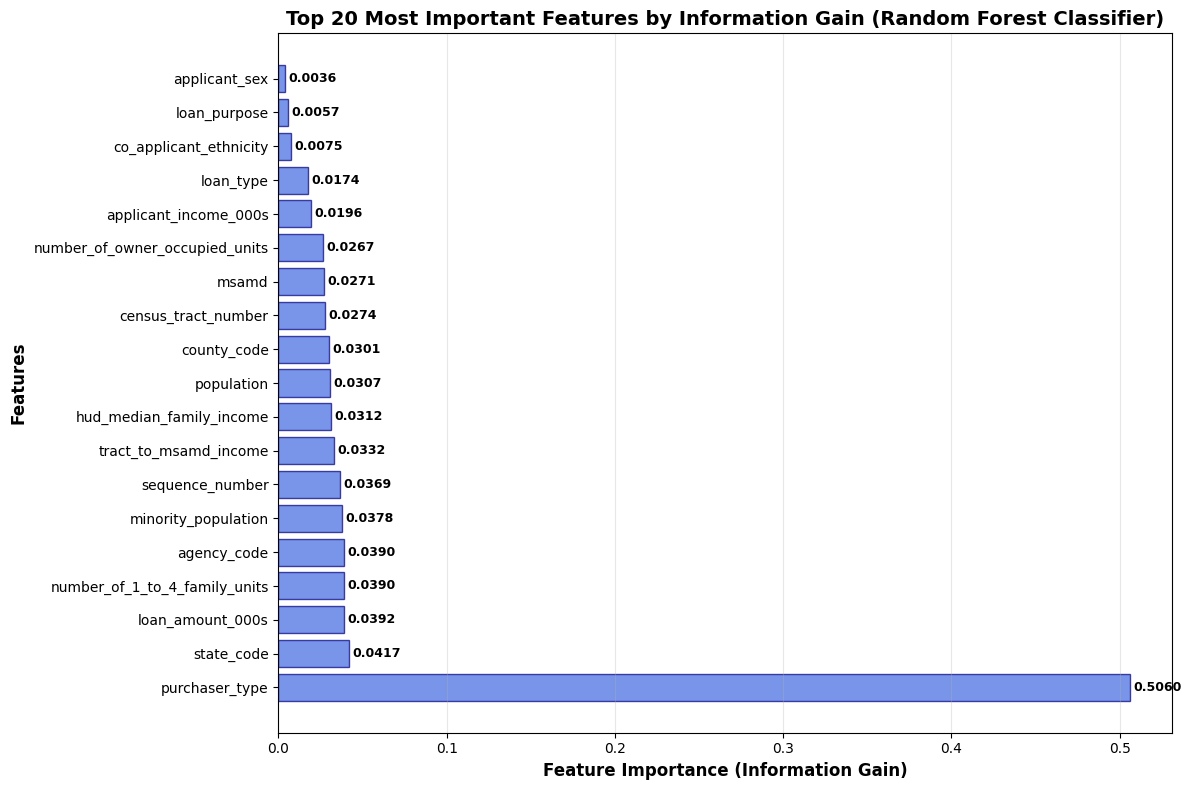


SUMMARY STATISTICS:
   • Total features analyzed: 19
   • Mean Information Gain: 0.052632
   • Top Feature: purchaser_type (IG: 0.505995)


In [9]:

# -------------------------------
# Assemble features
# -------------------------------
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df).select("features", "target")

# -------------------------------
# 2. Train Random Forest Classifier
# -------------------------------
rf = RandomForestClassifier(labelCol="target", featuresCol="features", 
                            numTrees=100, impurity="entropy", seed=42)

pipeline = Pipeline(stages=[assembler, rf])
rf_model = pipeline.fit(df)

# Extract the trained RF model 
rf_stage = rf_model.stages[-1]

# -------------------------------
# Extract Feature Importances
# -------------------------------
importances = rf_stage.featureImportances.toArray()

info_gain_df = pd.DataFrame({
    "feature": numeric_cols,
    "information_gain": importances
}).sort_values(by="information_gain", ascending=False)

# -------------------------------
#  Display Top 20 Features
# -------------------------------
top_20_features = info_gain_df.head(20)

print("\n" + "="*80)
print("TOP 20 FEATURES BY INFORMATION GAIN (From Random Forest)")
print("="*80)
print(f"{'Rank':<4} {'Feature':<35} {'Information Gain':<15}")
print("-"*80)

for i, (_, row) in enumerate(top_20_features.iterrows(), 1):
    print(f"{i:<4} {row['feature']:<35} {row['information_gain']:<15.6f}")

# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_20_features)), 
                top_20_features["information_gain"], 
                color="royalblue", edgecolor="navy", alpha=0.7)

plt.yticks(range(len(top_20_features)), top_20_features["feature"])
plt.xlabel("Feature Importance (Information Gain)", fontsize=12, fontweight='bold')
plt.ylabel("Features", fontsize=12, fontweight='bold')
plt.title("Top 20 Most Important Features by Information Gain (Random Forest Classifier)", 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add labels on bars
for bar, val in zip(bars, top_20_features["information_gain"]):
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# -------------------------------
# Summary
# -------------------------------
print("\nSUMMARY STATISTICS:")
print(f"   • Total features analyzed: {len(numeric_cols)}")
print(f"   • Mean Information Gain: {info_gain_df['information_gain'].mean():.6f}")
print(f"   • Top Feature: {top_20_features.iloc[0]['feature']} (IG: {top_20_features.iloc[0]['information_gain']:.6f})")


In [10]:
# Feature Selection Based on Random Forest Entropy Information Gain
print("FEATURE SELECTION BASED ON RANDOM FOREST ENTROPY")
print("="*60)

# Different selection criteria based on Random Forest feature importance
top_5 = info_gain_df.head(5)['feature'].tolist()
top_10 = info_gain_df.head(10)['feature'].tolist()
top_15 = info_gain_df.head(15)['feature'].tolist()
top_20 = info_gain_df.head(20)['feature'].tolist()

# Features with importance > mean + std
mean_importance = info_gain_df['information_gain'].mean()
std_importance = info_gain_df['information_gain'].std()
threshold = mean_importance + std_importance
high_importance = info_gain_df[info_gain_df['information_gain'] > threshold]['feature'].tolist()

# Features with importance > 0.01 (1%)
min_threshold = 0.01
above_min = info_gain_df[info_gain_df['information_gain'] > min_threshold]['feature'].tolist()

print(f"\nHigh Importance Features (> mean + std): {len(high_importance)}")
print(f"Threshold: {threshold:.6f}")
for i, feature in enumerate(high_importance, 1):
    ig_val = info_gain_df[info_gain_df['feature'] == feature]['information_gain'].iloc[0]
    print(f"  {i:2d}. {feature:<35} (IG: {ig_val:.6f})")

print(f"\nFeatures with IG > 0.01: {len(above_min)}")
for i, feature in enumerate(above_min, 1):
    ig_val = info_gain_df[info_gain_df['feature'] == feature]['information_gain'].iloc[0]
    print(f"  {i:2d}. {feature:<35} (IG: {ig_val:.6f})")

# Recommended selection based on Random Forest results
if len(high_importance) >= 5:
    recommended_features = high_importance
    print(f"\nRECOMMENDED: Using {len(high_importance)} high importance features (> mean + std)")
elif len(above_min) >= 5:
    recommended_features = above_min
    print(f"\nRECOMMENDED: Using {len(above_min)} features with IG > 0.01")
else:
    recommended_features = top_10
    print(f"\n RECOMMENDED: Using top 10 features")

# Create filtered dataset
final_columns = recommended_features + ['target']
df_selected = df.select(*final_columns)

print(f"\nFiltered dataset shape: {df_selected.count()} rows, {len(df_selected.columns)} columns")
print(f"Selected features: {recommended_features}")

# Feature importance summary for selected features
print(f"\n" + "="*60)
print("SELECTED FEATURES IMPORTANCE SUMMARY")
print("="*60)
print(f"{'Feature':<35} {'Information Gain':<15} {'Percentage'}")
print("-" * 60)

selected_info = info_gain_df[info_gain_df['feature'].isin(recommended_features)].sort_values('information_gain', ascending=False)
total_importance = selected_info['information_gain'].sum()

for _, row in selected_info.iterrows():
    percentage = (row['information_gain'] / total_importance) * 100
    print(f"{row['feature']:<35} {row['information_gain']:<15.6f} {percentage:.2f}%")

print(f" Selected {len(recommended_features)} most important features based on Random Forest entropy")


FEATURE SELECTION BASED ON RANDOM FOREST ENTROPY

High Importance Features (> mean + std): 1
Threshold: 0.163042
   1. purchaser_type                      (IG: 0.505995)

Features with IG > 0.01: 16
   1. purchaser_type                      (IG: 0.505995)
   2. state_code                          (IG: 0.041748)
   3. loan_amount_000s                    (IG: 0.039199)
   4. number_of_1_to_4_family_units       (IG: 0.039012)
   5. agency_code                         (IG: 0.038995)
   6. minority_population                 (IG: 0.037843)
   7. sequence_number                     (IG: 0.036899)
   8. tract_to_msamd_income               (IG: 0.033218)
   9. hud_median_family_income            (IG: 0.031200)
  10. population                          (IG: 0.030665)
  11. county_code                         (IG: 0.030075)
  12. census_tract_number                 (IG: 0.027447)
  13. msamd                               (IG: 0.027142)
  14. number_of_owner_occupied_units      (IG: 0.026680)
  1

## Model Evaluation

In [12]:
# Train and Evaluate Random Forest Classifier on Selected Features
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np

print("RANDOM FOREST CLASSIFIER TRAINING AND EVALUATION")
print("="*60)

# -------------------------------
# 1. Prepare Data with Selected Features
# -------------------------------
print("Preparing data with selected features...")

# Create feature vector from selected features
assembler = VectorAssembler(inputCols=recommended_features, outputCol="features")
df_vectorized = assembler.transform(df_selected)

# Show data info
print(f"Dataset shape: {df_vectorized.count()} rows, {len(df_vectorized.columns)} columns")
print(f"Selected features: {recommended_features}")



# -------------------------------
# 2. Train-Test Split
# -------------------------------
print("\nSplitting data into train and test sets...")
train_data, test_data = df_vectorized.randomSplit([0.7, 0.3], seed=42)

print(f"Training set: {train_data.count()} rows")
print(f"Test set: {test_data.count()} rows")


# -------------------------------
# 3. Train Random Forest Classifier
# -------------------------------
print("\nTraining Random Forest Classifier...")

# Create Random Forest with entropy (same as before)
rf = RandomForestClassifier(
    labelCol="target",
    featuresCol="features",
    numTrees=500,
    impurity="entropy",
    maxDepth=10,
    maxBins=32,
    seed=42
)

# Train the model
rf_model = rf.fit(train_data)

print(" Random Forest training completed!")

# -------------------------------
# 4. Make Predictions
# -------------------------------
print("\nMaking predictions...")

# Predictions on training set
train_predictions = rf_model.transform(train_data)

# Predictions on test set
test_predictions = rf_model.transform(test_data)

print(" Predictions completed!")

# -------------------------------
# 5. Model Evaluation
# -------------------------------
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

# Binary Classification Evaluator (for AUC)
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction")

# Multiclass Classification Evaluator (for accuracy, precision, recall, F1)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")

# Training set metrics
train_auc = binary_evaluator.evaluate(train_predictions)
train_accuracy = multi_evaluator.evaluate(train_predictions, {multi_evaluator.metricName: "accuracy"})
train_precision = multi_evaluator.evaluate(train_predictions, {multi_evaluator.metricName: "weightedPrecision"})
train_recall = multi_evaluator.evaluate(train_predictions, {multi_evaluator.metricName: "weightedRecall"})
train_f1 = multi_evaluator.evaluate(train_predictions, {multi_evaluator.metricName: "f1"})

# Test set metrics
test_auc = binary_evaluator.evaluate(test_predictions)
test_accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
test_precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
test_recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
test_f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})

# Display results
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 50)
print(f"{'AUC':<20} {train_auc:<15.4f} {test_auc:<15.4f}")
print(f"{'Accuracy':<20} {train_accuracy:<15.4f} {test_accuracy:<15.4f}")
print(f"{'Precision':<20} {train_precision:<15.4f} {test_precision:<15.4f}")
print(f"{'Recall':<20} {train_recall:<15.4f} {test_recall:<15.4f}")
print(f"{'F1-Score':<20} {train_f1:<15.4f} {test_f1:<15.4f}")

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
print(f"\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Get confusion matrix for test set
test_predictions.select("target", "prediction").groupBy("target", "prediction").count().show()

# Calculate confusion matrix values
confusion_matrix = test_predictions.groupBy("target", "prediction").count().collect()
conf_matrix = {}
for row in confusion_matrix:
    conf_matrix[(row.target, row.prediction)] = row['count']

# Display confusion matrix
print("Confusion Matrix (Test Set):")
print("                 Predicted")
print("Actual    0        1")
print(f"0        {conf_matrix.get((0, 0), 0):<8} {conf_matrix.get((0, 1), 0)}")
print(f"1        {conf_matrix.get((1, 0), 0):<8} {conf_matrix.get((1, 1), 0)}")

# -------------------------------
# 9. Model Summary
# -------------------------------
print(f" Training Samples: {train_data.count()}")
print(f"Test Samples: {test_data.count()}")

print(f"\n Performance Summary:")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test AUC: {test_auc:.4f}")
print(f"   • Test F1-Score: {test_f1:.4f}")


print(f"\n Random Forest training and evaluation completed!")

RANDOM FOREST CLASSIFIER TRAINING AND EVALUATION
Preparing data with selected features...
Dataset shape: 120 rows, 18 columns
Selected features: ['purchaser_type', 'state_code', 'loan_amount_000s', 'number_of_1_to_4_family_units', 'agency_code', 'minority_population', 'sequence_number', 'tract_to_msamd_income', 'hud_median_family_income', 'population', 'county_code', 'census_tract_number', 'msamd', 'number_of_owner_occupied_units', 'applicant_income_000s', 'loan_type']

Splitting data into train and test sets...
Training set: 80 rows
Test set: 40 rows

Training Random Forest Classifier...
 Random Forest training completed!

Making predictions...
 Predictions completed!

MODEL EVALUATION RESULTS


25/10/27 12:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1895.8 KiB
25/10/27 12:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1908.3 KiB
25/10/27 12:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1908.3 KiB
25/10/27 12:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1908.3 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1908.3 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1895.8 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1908.2 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1908.2 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1908.2 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1908.2 KiB
25/10/27 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1903.9 KiB


Metric               Training        Test           
--------------------------------------------------
AUC                  1.0000          0.9336         
Accuracy             1.0000          0.9250         
Precision            1.0000          0.9352         
Recall               1.0000          0.9250         
F1-Score             1.0000          0.9249         

CONFUSION MATRIX


25/10/27 12:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1929.8 KiB
25/10/27 12:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1903.9 KiB
25/10/27 12:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1928.3 KiB


+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|    3|
|     0|       0.0|   19|
|     1|       1.0|   18|
+------+----------+-----+

Confusion Matrix (Test Set):
                 Predicted
Actual    0        1
0        19       0
1        3        18
 Training Samples: 80
Test Samples: 40

 Performance Summary:
   • Test Accuracy: 0.9250 (92.50%)
   • Test AUC: 0.9336
   • Test F1-Score: 0.9249

 Random Forest training and evaluation completed!
